# Workshop: Explaining and Interpreting XGBoost Models

### This workshop will focus on two primary objectives:

#### Understanding the overall dynamics of your data and your model:

- Using more sophisticated modeling packages (like XGBoost) to understand more complicated dynamics in the data

- How to approach data exploration to understand more complicated relationships between the variables in your data

- Why the "coherence" of a model is important - arguably, on the same level as its predictive performance

- How to assess the "coherence" of a model using ICE plots 

#### Understanding and explaining individual predictions from the model

- How to ascribe "reasons" to individual predictions

- How to "consolidate" features to make the reasons more coherent and understandable


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')  # I prefer the appearance of the "old-school" color scheme

%matplotlib inline
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, accuracy_score, r2_score, roc_curve, precision_recall_curve
import xgboost as xgb


pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)
np.set_printoptions(edgeitems=30, linewidth=100000)


In [2]:
# must have ml_insights installed ('pip install ml_insights')
import ml_insights as mli

## Load data

You can get the data at:

https://drive.google.com/file/d/1UDIemsSUseF5yyv5BEABlLOKSeCnfZeo/view?usp=sharing

or

https://bit.ly/2V2tAdw

Download the file and place in the same directory as the notebook.

In [3]:
df_ins = pd.read_csv('ins_data_ODSC_East_2019.csv')
df_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10670 entries, 0 to 10669
Data columns (total 20 columns):
Unnamed: 0                   10670 non-null int64
has_umbrella                 10670 non-null int64
homeown_premium              10670 non-null float64
auto_premium                 10670 non-null float64
num_home_pol                 10670 non-null float64
home_dwell_cov               8781 non-null float64
home_pers_prop_cov           10015 non-null float64
num_vehicles                 10514 non-null float64
max_vehicle_year             10514 non-null float64
min_vehicle_year             10514 non-null float64
num_drivers_by_dob           10670 non-null float64
yob_policyholder             8706 non-null float64
max_driver_yob               9334 non-null float64
min_driver_yob               9334 non-null float64
state_abbrev                 10632 non-null object
avg_homeown_rate_in_state    10632 non-null float64
median_household_income      10518 non-null float64
median_house_val

## Data Exploration
This data set contains information about different insurance customers who have both home insurance and auto insurance with an agency.  The information includes their premiums, coverages, vehicles, drivers, state of residence, and zip-code demographics.


In this exercise we will be building a model to predict who is likely to have an umbrella policy.  Imagine, that our goal is to be able to recommend to new agencies (which currently don't sell umbrella policies) which customers are the best candidates.  Our binary outcome variable is `has_umbrella` 

We will focus on techniques for exploring, understanding, and interpreting data and models in a binary classification framework.


### Look at the "baseline" (marginal) probability of the outcome variable
It is always a good idea to know ahead of time what the baseline probability of your outcome variable is.  Without this information, it is difficult to properly interpret the effectiveness of your model.

In [4]:
df_ins.has_umbrella.value_counts(), np.mean(df_ins.has_umbrella)

(0    9457
 1    1213
 Name: has_umbrella, dtype: int64, 0.11368322399250234)

### Initial Predictors
To start, let's look only at the variables `homeown_premium` and `auto_premium` and see how they relate to the outcome variable `has_umbrella`

(array([9.894e+03, 6.010e+02, 1.070e+02, 3.800e+01, 1.300e+01, 9.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 4.000e+00]),
 array([    0.,  2270.,  4540.,  6810.,  9080., 11350., 13620., 15890., 18160., 20430., 22700.]),
 <a list of 10 Patch objects>)

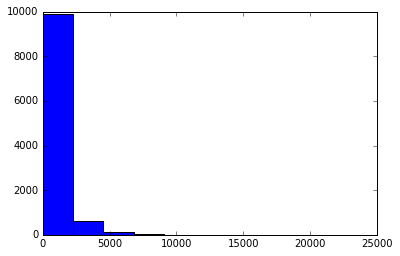

In [5]:
plt.hist(df_ins.homeown_premium)

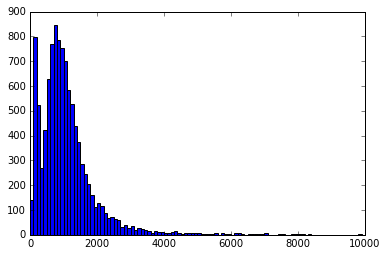

In [6]:
plt.hist(df_ins.homeown_premium, bins=np.linspace(0,10000,101));

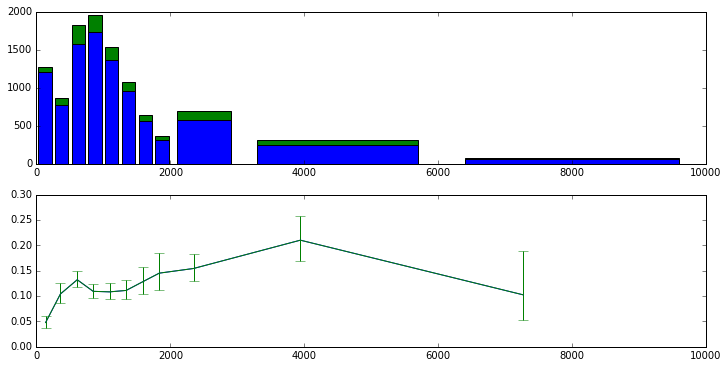

In [7]:
bins_1 = np.linspace(0,2000,9)
bins_2 = np.array([2000,3000, 6000, 10000])
bins_final = np.unique(np.concatenate((bins_1, bins_2)))
mli.histogram_pair(df_ins.homeown_premium, df_ins.has_umbrella, bins=bins_final);

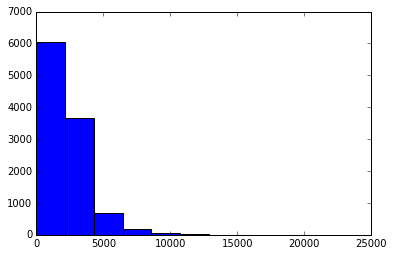

In [8]:
plt.hist(df_ins.auto_premium);

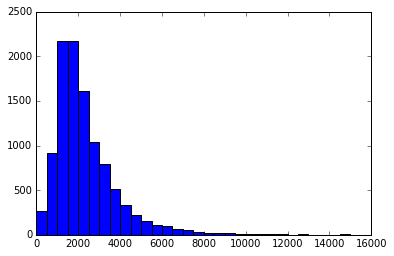

In [9]:
plt.hist(df_ins.auto_premium,np.linspace(0,15000,30+1));

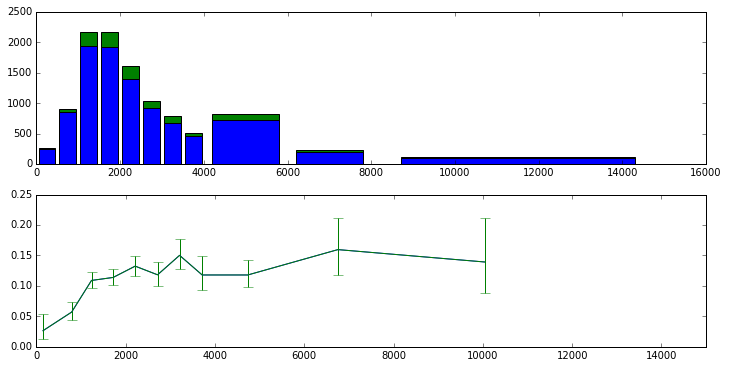

In [10]:
bins_1 = np.linspace(0,4000,8+1)
bins_2 = np.array([4000,6000, 8000, 15000])
bins_final = np.unique(np.concatenate((bins_1, bins_2)))
mli.histogram_pair(df_ins.auto_premium, df_ins.has_umbrella, bins=bins_final);

In [11]:
## Could do this on all the variables to understand...

## Simple model: 2 variables

It is often a good idea to build a model on a small number of variables first, just to get a sense of the behavior.

In [12]:
chosen_fold_variant = 'fold_num_1'
test_fold_num = 0

In [13]:
features_1 = ['auto_premium','homeown_premium']

## Question
- ###  How high do you expect your precision to get? (at, say, recall=.1)

In [14]:
# Define train and test sets

X_train_1 = df_ins.loc[df_ins[chosen_fold_variant]!=test_fold_num,features_1]
X_test_1 = df_ins.loc[df_ins[chosen_fold_variant]==test_fold_num,features_1]

y_train = df_ins.has_umbrella[df_ins[chosen_fold_variant]!=test_fold_num]
y_test = df_ins.has_umbrella[df_ins[chosen_fold_variant]==test_fold_num]

### First model - default XGBoost

In [15]:
xgb_def1 = xgb.XGBClassifier()

In [16]:
xgb_def1.fit(X_train_1,y_train)
pred_probs_def1 = xgb_def1.predict_proba(X_test_1)[:,1]

### Question: How should we evaluate this model?

In [17]:
roc_auc_score(y_test, pred_probs_def1), log_loss(y_test, pred_probs_def1)

(0.5888486568695068, 0.3534640339527233)

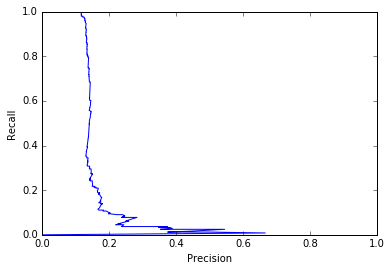

In [18]:
mli.plot_pr_curves([y_test],[pred_probs_def1])

### To Do: Perform your own evaluation of the model here

## Other less utilized ways to "examine" your model
- ### Calibration (Reliability Diagram)
- ### Variation to individual Parameter changes (Individual Conditional Expectation (ICE) plots)
- ### Coherence - does the "story" of the model hold together?

### Calibration
#### Idea: When your model predicts probability of 20%, does it really happen 20% of the time?
#### Method: 
- #### Look at test set when your model predicted outcome 1 with a probability of (approximately) 20%.  
- #### Look at fraction that actually occured.
- #### Determine if it is within the expected range of frequency if the probability were accurate
- #### Doing this requires *binning* the data

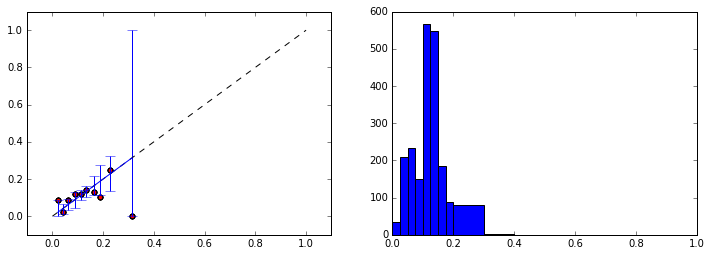

In [19]:
plt.figure(figsize=(12,4))
bins1 = np.linspace(0,.2,8+1)
bins2 = np.linspace(.2,1,8+1)
bins_final = np.unique(np.concatenate((bins1, bins2)))

mli.plot_reliability_diagram(y_test,pred_probs_def1,size_points=False, bins=bins_final);

### Question: What do you think of the above reliability diagram?

### Individual Conditional Expectation Plot
### Idea: 
- #### Hold all features constant except for one.
- #### Vary the value of the feature over a range of values
- #### Examine how the model prediction changes
- #### Examine how the response curve may take different shapes (because of interactions)

In [20]:
### Define an example set
X_explore_1 =  X_test_1.sample(100)

### "Mutate" the data points and make predictions on them
mxr_def_1 = mli.ModelXRay(xgb_def1,X_explore_1)

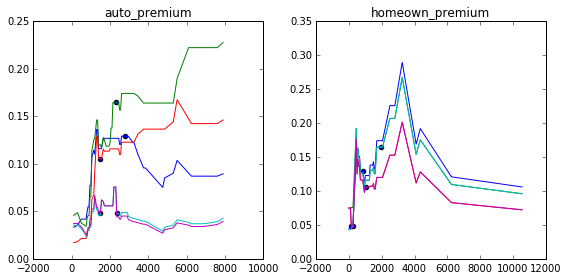

In [21]:
### Visualize the responses
indices = mxr_def_1.feature_dependence_plots()

## Question: What do you think about these ICE plots?

### Second model: Let's try adding a bit more regularization

In [22]:
xgb_complex1 = xgb.XGBClassifier(n_estimators=1000, learning_rate=.01, gamma=5, max_depth=2, subsample=.9, 
                                 reg_lambda=3, reg_alpha=2)


In [23]:
xgb_complex1.fit(X_train_1,y_train, eval_metric='logloss')#, eval_set=[(X_test_1, y_test)])
pred_probs_complex_1 = xgb_complex1.predict_proba(X_test_1)[:,1]


In [24]:
## Performance of this model
roc_auc_score(y_test, pred_probs_complex_1), log_loss(y_test, pred_probs_complex_1)

(0.5894897165190021, 0.3529605643133019)

In [25]:
## Performance of previous model
roc_auc_score(y_test, pred_probs_def1), log_loss(y_test, pred_probs_def1)

(0.5888486568695068, 0.3534640339527233)

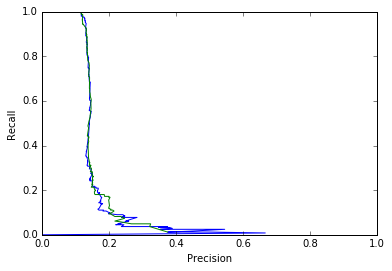

In [26]:
mli.plot_pr_curves([y_test,y_test],[pred_probs_def1,pred_probs_complex_1])

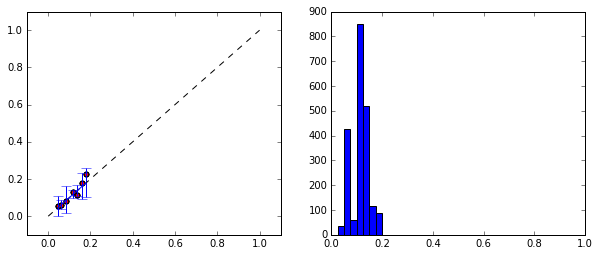

In [27]:
bins1 = np.linspace(0,.2,8+1)
bins2 = np.linspace(.2,1,8+1)
bins_final = np.unique(np.concatenate((bins1, bins2)))
plt.figure(figsize=(10,4))
mli.plot_reliability_diagram(y_test,pred_probs_complex_1,size_points=False, 
                             bins=bins_final);

In [28]:
### Examine Model More Deeply

mxr_complex_1 = mli.ModelXRay(xgb_complex1,X_explore_1)

array([98, 81, 67, 84, 86])

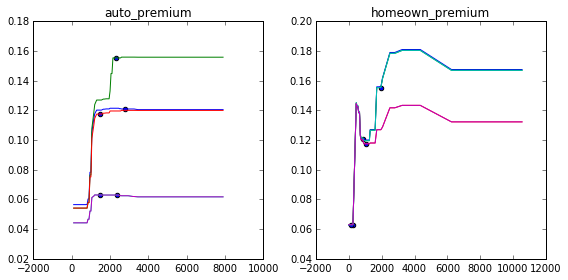

In [29]:
mxr_complex_1.feature_dependence_plots(pts_selected=indices)

array([98, 81, 67, 84, 86])

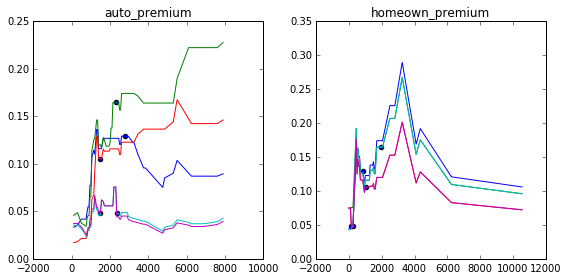

In [30]:
mxr_def_1.feature_dependence_plots(pts_selected=indices)

## Questions
- ### Which model looks more "coherent" ?
- ### Which model would you feel more comfortable justifying to your boss / clients?
- ### Which model do you expect to generalize better to new cases?

## One more question
- ### What do you think accounts for the non-monotonicity of the response wrt the premiums?

### Next model: Add in one additional feature

In [31]:
features_1a = ['auto_premium','homeown_premium'
                 ,'avg_homeown_rate_in_state']

In [32]:
X_train_1a = df_ins.loc[df_ins[chosen_fold_variant]!=test_fold_num,features_1a]
X_test_1a = df_ins.loc[df_ins[chosen_fold_variant]==test_fold_num,features_1a]


In [33]:
xgb_complex1a= xgb.XGBClassifier(n_estimators=1000, learning_rate=.02, gamma=6, max_depth=3, subsample=.8, 
                                 reg_lambda=3, reg_alpha=2)


In [34]:
xgb_complex1a.fit(X_train_1a,y_train, eval_metric='logloss')#, eval_set=[(X_test_1a, y_test)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=6, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2, reg_lambda=3, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [35]:
pred_probs_complex_1a = xgb_complex1a.predict_proba(X_test_1a)[:,1]

In [36]:
roc_auc_score(y_test, pred_probs_complex_1a), log_loss(y_test, pred_probs_complex_1a)

(0.8154378216350999, 0.29023833870905513)

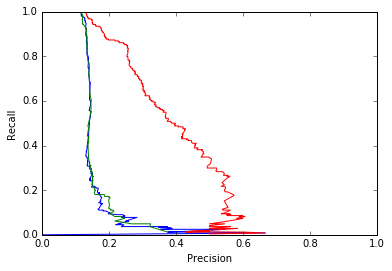

In [37]:
mli.plot_pr_curves([y_test,y_test, y_test],[pred_probs_def1,pred_probs_complex_1, pred_probs_complex_1a])

In [38]:
X_explore_1a = X_test_1a.sample(100)
mxr1a = mli.ModelXRay(xgb_complex1a,X_explore_1a)

array([75, 41,  9, 11, 74])

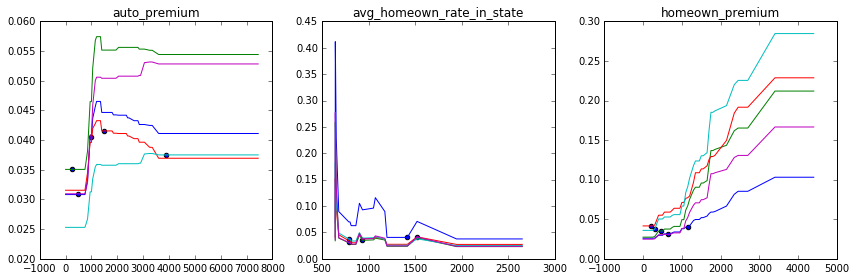

In [39]:
mxr1a.feature_dependence_plots()

## Question
- ### What conclusions do you draw from the shapes of the curves above?

### Next model: Add in a bunch more variables

In [40]:
features_2 = ['auto_premium','homeown_premium', 'home_dwell_cov', 'home_pers_prop_cov',
                'num_home_pol',
                'yob_policyholder','min_vehicle_year', 'max_vehicle_year', 'num_vehicles',
                  'max_driver_yob', 'min_driver_yob',
                'median_household_income','median_house_value'
                  ,'avg_homeown_rate_in_state'
                ]

In [41]:
X_train_2 = df_ins.loc[df_ins[chosen_fold_variant]!=test_fold_num,features_2]
X_test_2 = df_ins.loc[df_ins[chosen_fold_variant]==test_fold_num,features_2]


In [42]:
xgb_complex2 = xgb.XGBClassifier(n_estimators = 1500, learning_rate=.03, max_depth=4, subsample=.8, gamma=6, 
                                 reg_alpha=2, reg_lambda=5, colsample_bytree=.7, colsample_bylevel=.7)
xgb_complex2.fit(X_train_2,y_train, eval_metric='logloss')#, eval_set=[(X_test_2, y_test)])
pred_probs_complex2 = xgb_complex2.predict_proba(X_test_2)[:,1]

In [43]:
roc_auc_score(y_test, pred_probs_complex2), log_loss(y_test, pred_probs_complex2)

(0.8646258864307567, 0.2578766246970381)

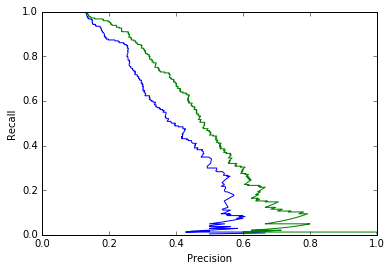

In [44]:
mli.plot_pr_curves([y_test, y_test],[pred_probs_complex_1a,pred_probs_complex2])

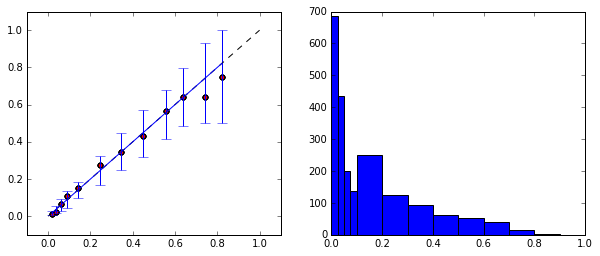

In [45]:
bins1 = np.linspace(0,.1,5)
bins2 = np.linspace(.2,1,9)
bins_final = np.unique(np.concatenate((bins1, bins2)))
plt.figure(figsize = (10,4))
mli.plot_reliability_diagram(y_test,pred_probs_complex2,size_points=False, 
                             bins=bins_final);

In [46]:
X_explore_2 =  X_test_2[X_test_2.median_house_value<1000000].sample(100)
mxr_complex2 = mli.ModelXRay(xgb_complex2,X_explore_2)

array([98, 81, 67, 84, 86])

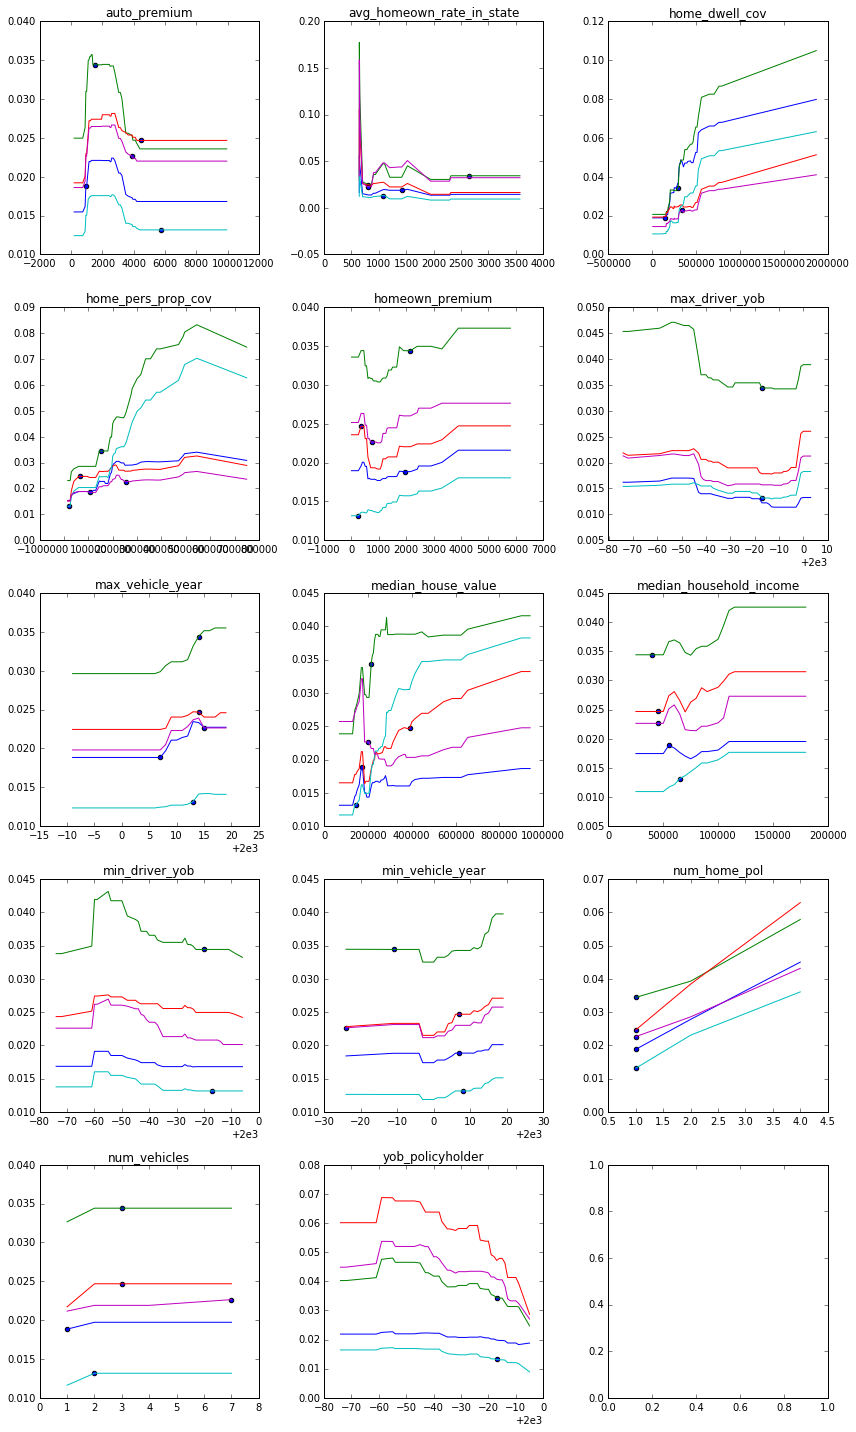

In [47]:
mxr_complex2.feature_dependence_plots(pts_selected=indices)

array([98, 81, 67, 84, 86])

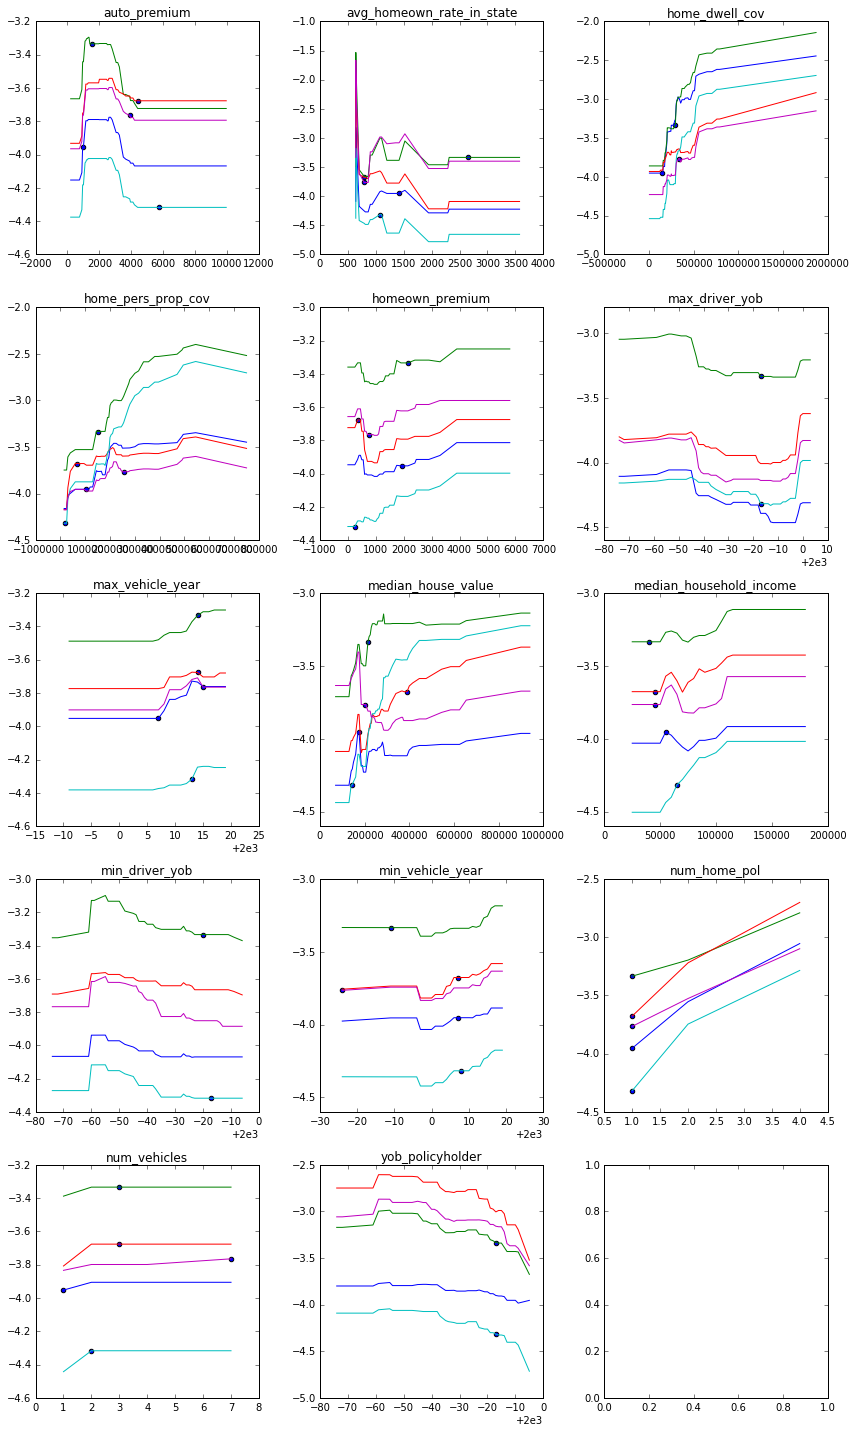

In [48]:
mxr_complex2.feature_dependence_plots(pts_selected=indices, y_scaling='logit')

### For comparison sake, let's look at the default XGB settings

In [49]:
xgb_def2 = xgb.XGBClassifier()
xgb_def2.fit(X_train_2,y_train)
pred_probs_def2 = xgb_def2.predict_proba(X_test_2)[:,1]

In [50]:
roc_auc_score(y_test, pred_probs_def2), log_loss(y_test, pred_probs_def2)

(0.8668707004792474, 0.2570833804383714)

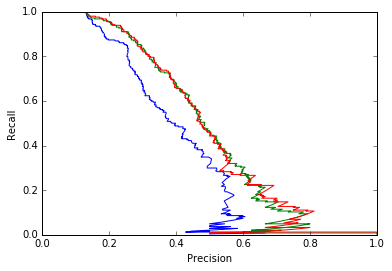

In [51]:
mli.plot_pr_curves([y_test, y_test, y_test],[pred_probs_complex_1a,pred_probs_complex2, pred_probs_def2])

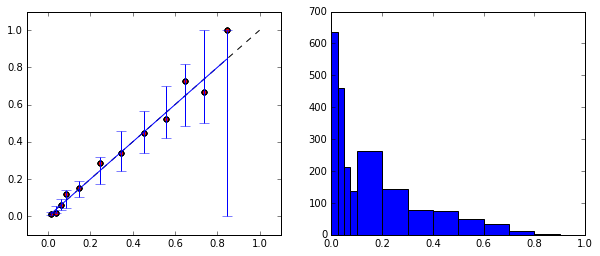

In [52]:
bins1 = np.linspace(0,.1,5)
bins2 = np.linspace(.2,1,9)
bins_final = np.unique(np.concatenate((bins1, bins2)))
plt.figure(figsize = (10,4))
mli.plot_reliability_diagram(y_test,pred_probs_def2,size_points=False, 
                             bins=bins_final);

In [53]:
mxr_def2 = mli.ModelXRay(xgb_def2,X_explore_2)

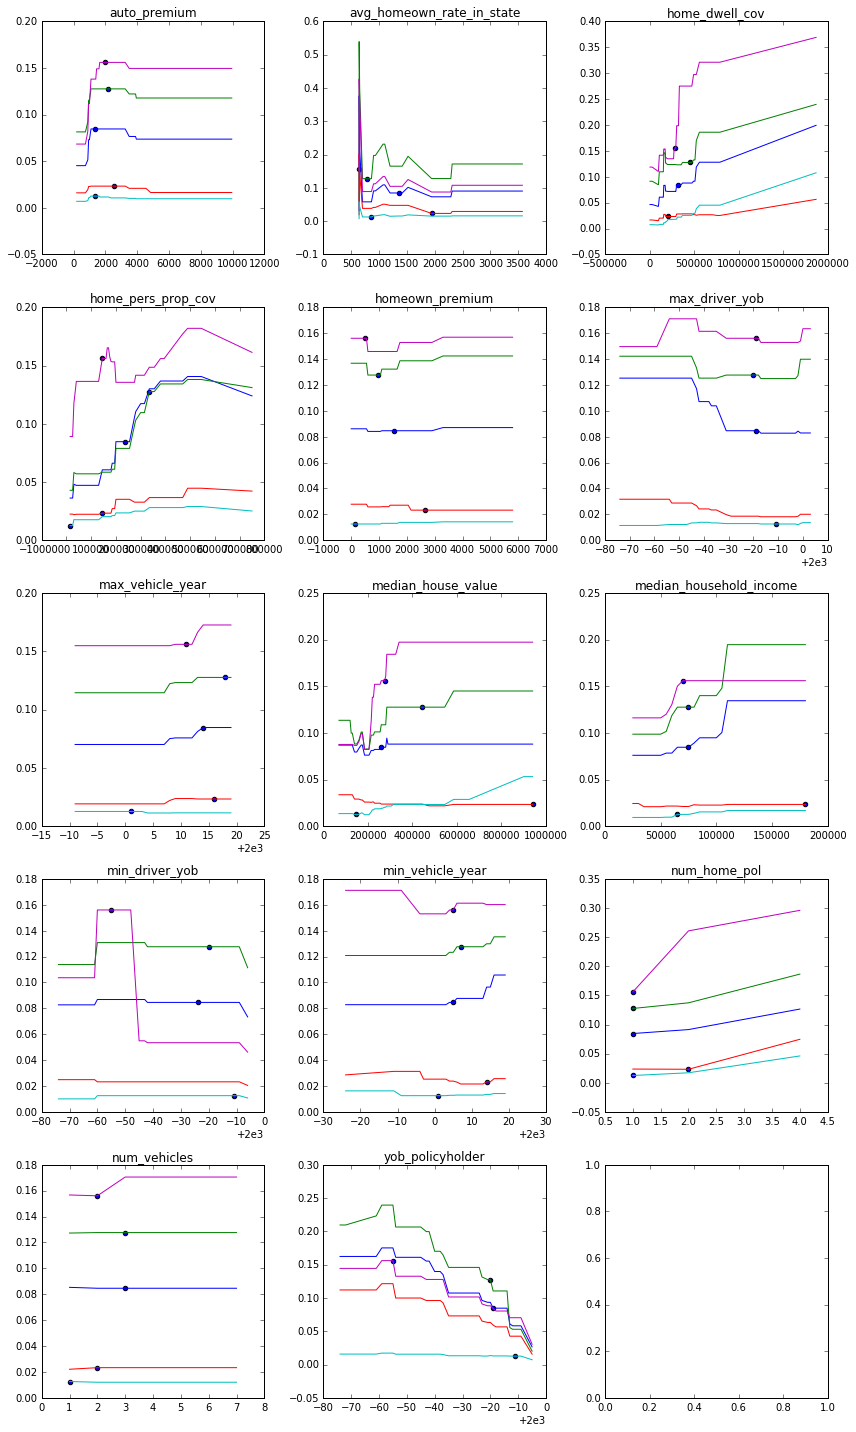

In [54]:
indices = mxr_def2.feature_dependence_plots()

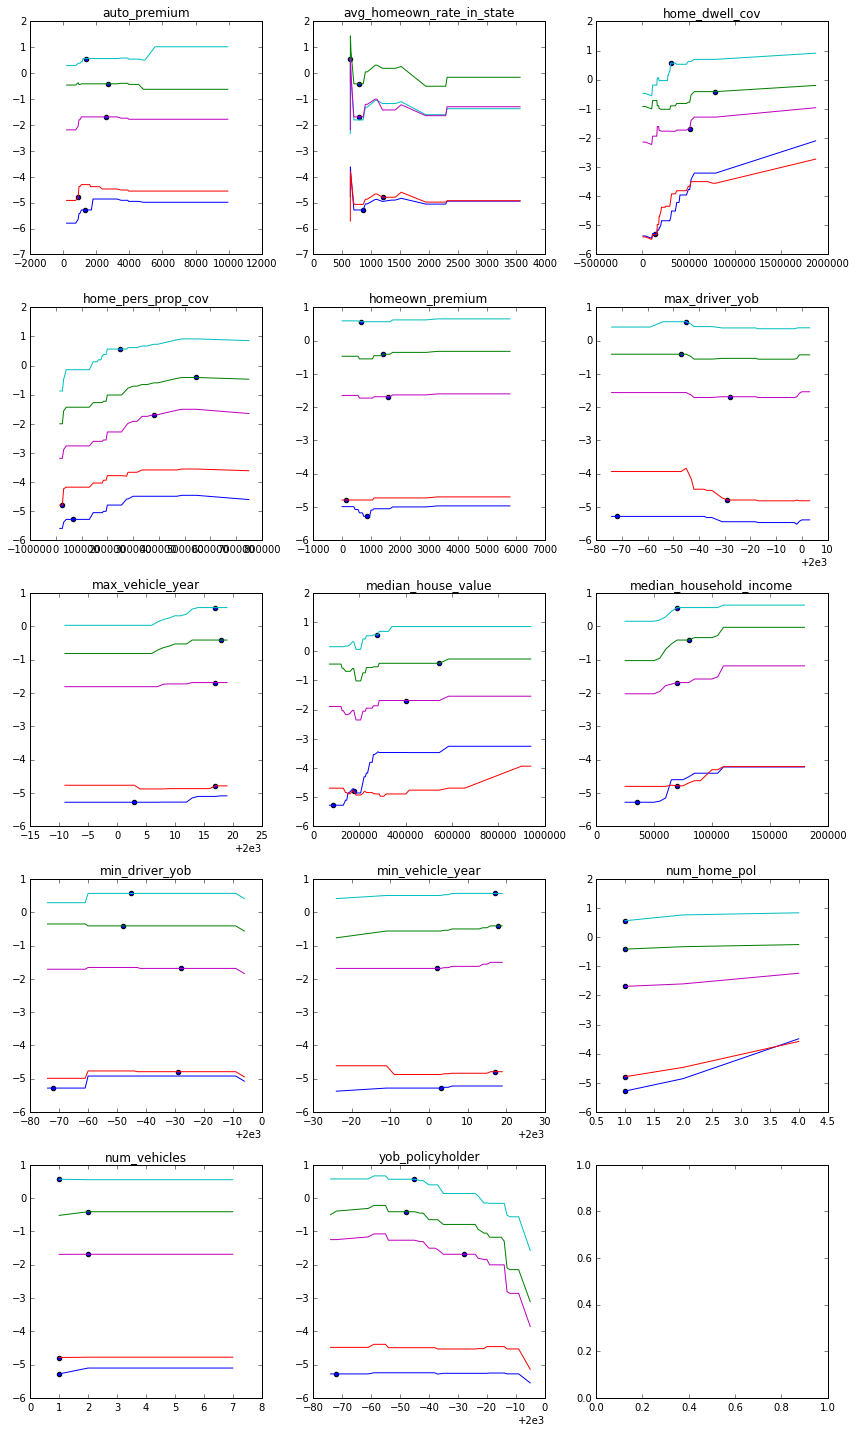

In [55]:
indices = mxr_def2.feature_dependence_plots(y_scaling='logit')

## Summary of Part I
- ### Model understanding is still possible even when models are more complex
- ### Need to broaden your thinking beyond the assumptions of linear / logistic regression
- ### Effects of a variable are not constant across its range of values (non-linearity)
- ### Shape of the response curve may vary depending on values of other variables (interactions)
- ### But can still explore and understand them!



## If we have time....

In [56]:
def auc_sim(prob_vec, num_trials=1000):
    out_vec = np.zeros(num_trials)
    for i in range(num_trials):
        sample_results = np.random.binomial(n=1, p=prob_vec)
        out_vec[i] = roc_auc_score(sample_results, prob_vec)
    return(out_vec)

In [57]:
sample_auc_scores = auc_sim(pred_probs_complex2)


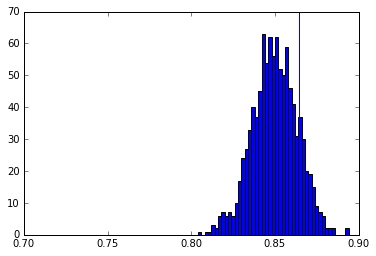

In [58]:
plt.hist(sample_auc_scores, bins = np.linspace(.7,.9,100+1));
plt.axvline(roc_auc_score(y_test, pred_probs_complex2))

In [59]:
def log_loss_sim(prob_vec, num_trials=1000):
    out_vec = np.zeros(num_trials)
    for i in range(num_trials):
        sample_results = np.random.binomial(n=1, p=prob_vec)
        out_vec[i] = log_loss(sample_results, prob_vec)
    return(out_vec)

In [60]:
sample_log_loss_scores = log_loss_sim(pred_probs_complex2, num_trials=5000)

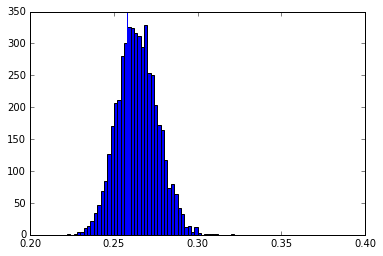

In [61]:
plt.hist(sample_log_loss_scores, bins = np.linspace(.2,.4,101));
plt.axvline(log_loss(y_test, pred_probs_complex2))

## Part II: Giving reasons to model predictions

- ### In the previous, we focused our attention to understanding the overall dynamics of the model.

- ### However, in many cases,  we want to understand the reasons behind a specific prediction.

## Goal: 
- ### Explain why a particular instance is "different" from average
- ### Which features / concepts contributed most to its "distinctiveness"?

## SHAP

### Idea: 

- #### arbitrarily order the features $X_1, X_2, \ldots, X_k$.

- #### Compare $P(Y=1|X_1 = x_1, X_2 = x_2, \ldots, X_{j-1}=x_{j-1})$ to $P(Y=1|X_1 = x_1, X_2 = x_2, \ldots, X_j=x_j)$ (actually, compare the log odds) and attribute the difference to feature $X_j$ being equal to $x_j$.

- #### Average the "attributions" to a feature over all possible orderings of the features

### This is motivated by the "Shapley Value" in Game Theory 
### Same approach attributes ~98% of the "power" in the Security Council to the 5 permanent members

The "magic" of SHAP is that step (3) (averaging over all possible orderings) is typically computationally prohibitive, but for tree-based models they found a clever way to compute it by exploiting the structure.

### References
*A Unified Approach to Interpreting Model Predictions*
Scott Lundberg, Su-In Lee
https://arxiv.org/abs/1705.07874

*Consistent Individualized Feature Attribution for Tree Ensembles*
Scott M. Lundberg, Gabriel G. Erion, Su-In Lee
https://arxiv.org/abs/1802.03888


In [62]:
reas_df = mli.get_reason_score_matrix(xgb_complex2, X_test_2)
reas_df.round(decimals=2).head()

,auto_premium,homeown_premium,home_dwell_cov,home_pers_prop_cov,num_home_pol,yob_policyholder,min_vehicle_year,max_vehicle_year,num_vehicles,max_driver_yob,min_driver_yob,median_household_income,median_house_value,avg_homeown_rate_in_state,Intercept
0,0.10,-0.05,-0.23,-0.19,-0.04,-0.22,-0.04,-0.09,0.03,-0.12,-0.08,-0.17,-0.47,-0.03,-2.17
1,-0.06,-0.08,0.09,0.10,-0.03,0.12,-0.04,-0.07,0.02,0.13,-0.04,-0.14,0.24,-0.71,-2.17
2,0.01,-0.01,-0.21,-0.41,-0.03,0.22,-0.06,-0.11,0.03,-0.01,0.02,-0.03,-0.00,-0.46,-2.17
3,-0.19,0.00,-0.16,-0.28,-0.03,-0.71,-0.04,0.04,0.03,0.23,0.03,0.02,-0.16,-0.29,-2.17
4,-0.18,-0.06,-0.44,-0.29,-0.03,-0.55,-0.00,-0.03,0.03,0.18,0.01,-0.11,-0.28,-0.60,-2.17


In [63]:
## Look at correlations between the reasons
pd.DataFrame(np.round(np.corrcoef(reas_df.values[:,:-1].T), decimals=2), columns = reas_df.columns[:-1], index = reas_df.columns[:-1])

,auto_premium,homeown_premium,home_dwell_cov,home_pers_prop_cov,num_home_pol,yob_policyholder,min_vehicle_year,max_vehicle_year,num_vehicles,max_driver_yob,min_driver_yob,median_household_income,median_house_value,avg_homeown_rate_in_state
auto_premium,1.00,-0.07,-0.01,-0.02,0.00,0.05,0.02,0.16,0.12,-0.08,-0.08,0.04,0.08,0.09
homeown_premium,-0.07,1.00,0.20,0.19,0.09,0.04,0.05,0.02,0.05,0.04,0.04,0.13,0.15,0.14
home_dwell_cov,-0.01,0.20,1.00,0.77,0.15,0.05,0.06,0.16,0.23,0.00,0.06,0.35,0.44,0.06
home_pers_prop_cov,-0.02,0.19,0.77,1.00,0.14,0.11,0.02,0.14,0.29,0.05,0.12,0.29,0.32,0.07
num_home_pol,0.00,0.09,0.15,0.14,1.00,0.01,0.01,0.03,0.05,0.09,0.07,0.07,0.07,-0.07
yob_policyholder,0.05,0.04,0.05,0.11,0.01,1.00,-0.04,0.02,0.04,-0.01,0.46,0.02,-0.01,0.23
min_vehicle_year,0.02,0.05,0.06,0.02,0.01,-0.04,1.00,0.40,-0.31,-0.01,-0.04,0.15,0.04,-0.07
max_vehicle_year,0.16,0.02,0.16,0.14,0.03,0.02,0.40,1.00,0.17,-0.08,-0.05,0.15,0.07,-0.07
num_vehicles,0.12,0.05,0.23,0.29,0.05,0.04,-0.31,0.17,1.00,-0.07,-0.02,0.04,0.06,0.00
max_driver_yob,-0.08,0.04,0.00,0.05,0.09,-0.01,-0.01,-0.08,-0.07,1.00,0.57,-0.07,0.00,-0.06


In [64]:
## get_reason_matrix is essentially the following 3 lines
# X_test_dmat = xgb.DMatrix(X_test_2)
# reas_mat = xgb_complex2.get_booster().predict(X_test_dmat, pred_contribs=True)
# reas_df_2 = pd.DataFrame(reas_mat, columns = list(X_test_2.columns)+['Intercept'])
# reas_df_2.head()

In [65]:
## Demonstrate that these numbers sum up to the overall log_odds

log_odds_vec = np.sum(reas_df, axis=1)
pv = 1/(1+np.exp(-log_odds_vec))
np.sum(np.abs(pv- pred_probs_complex2)>.0001)

0

In [66]:
# Get the average "impact" of each variable
reas_df.abs().mean().sort_values(ascending=False)

Intercept                    2.173351
avg_homeown_rate_in_state    0.488573
yob_policyholder             0.339692
home_pers_prop_cov           0.306299
home_dwell_cov               0.300276
median_house_value           0.247167
median_household_income      0.125899
max_driver_yob               0.111540
auto_premium                 0.107853
min_driver_yob               0.067414
max_vehicle_year             0.062757
num_home_pol                 0.058476
min_vehicle_year             0.054715
num_vehicles                 0.054592
homeown_premium              0.048778
dtype: float32

In [67]:
def analyze_effect(feature_name, reas_df, test_df, fillna_val=0):
    plt.subplot(2,2,1)
    plt.scatter(test_df[feature_name].fillna(fillna_val), reas_df[feature_name], alpha=.1)
    plt.subplot(2,2,2)
    plt.scatter(reas_df[feature_name], test_df[feature_name].fillna(fillna_val), alpha=.1)
    plt.subplot(2,2,3)
    plt.hist(test_df[feature_name].fillna(fillna_val))
    plt.subplot(2,2,4)
    plt.hist(reas_df[feature_name])
                

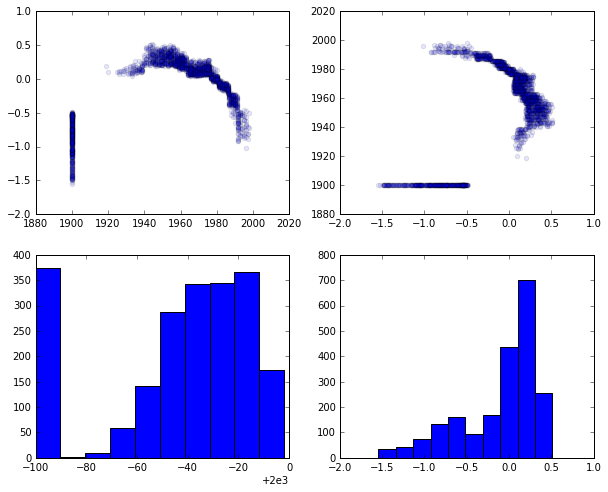

In [68]:
plt.figure(figsize=(10,8))
analyze_effect('yob_policyholder',reas_df, X_test_2, fillna_val=1900)

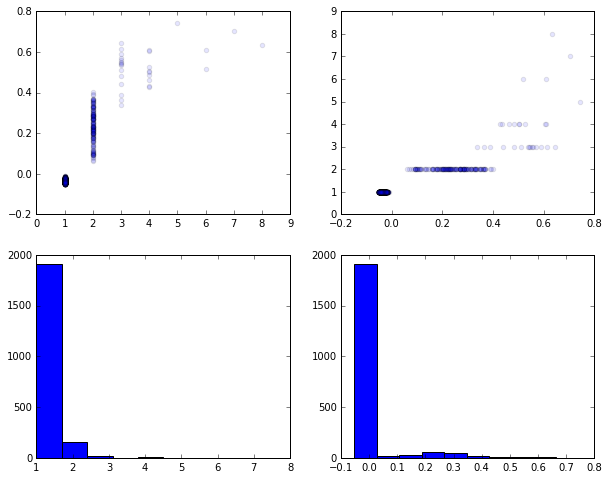

In [69]:
plt.figure(figsize=(10,8))
analyze_effect('num_home_pol',reas_df, X_test_2, fillna_val=0)

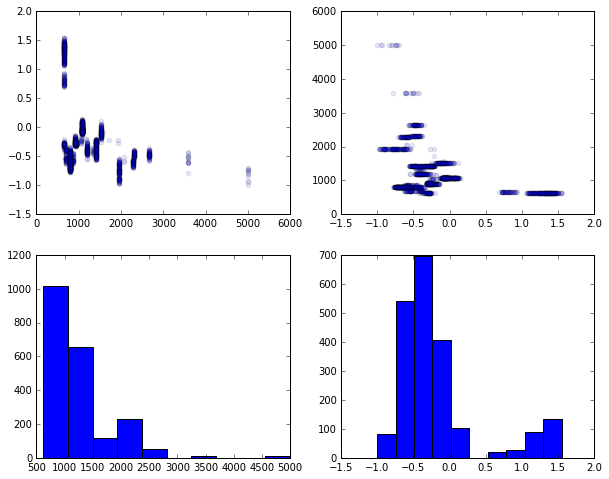

In [70]:
plt.figure(figsize=(10,8))
analyze_effect('avg_homeown_rate_in_state',reas_df, X_test_2, fillna_val=5000)

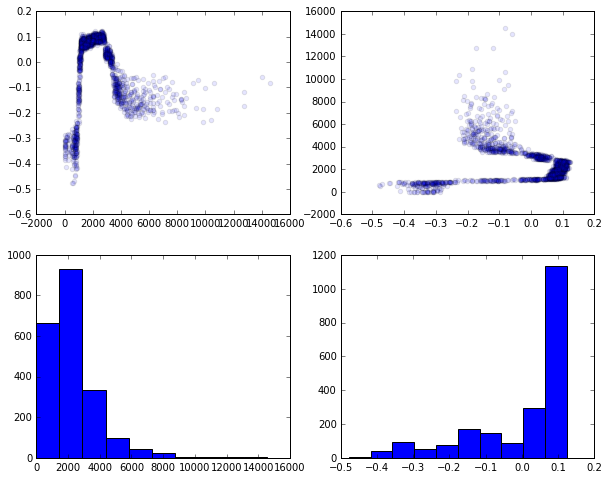

In [71]:
plt.figure(figsize=(10,8))
analyze_effect('auto_premium',reas_df, X_test_2, fillna_val=-1000)

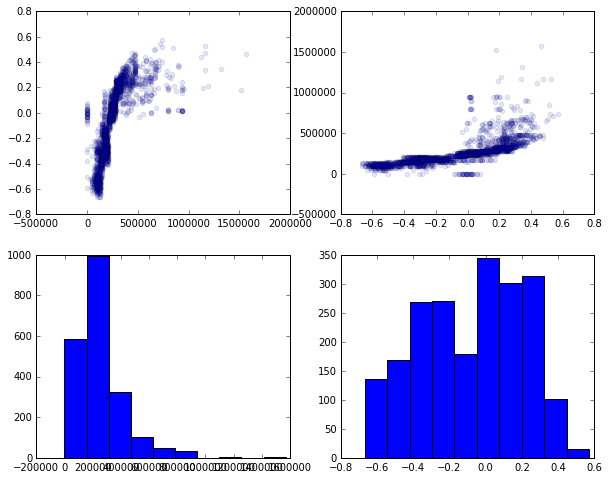

In [72]:
plt.figure(figsize=(10,8))
analyze_effect('median_house_value',reas_df, X_test_2, fillna_val=-1000)

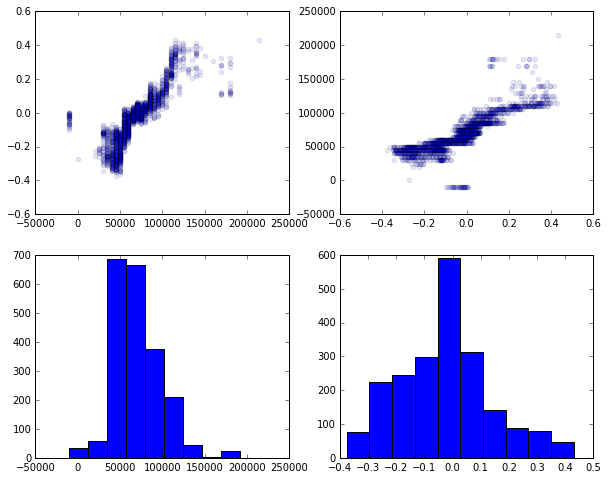

In [73]:
plt.figure(figsize=(10,8))
analyze_effect('median_household_income',reas_df, X_test_2, fillna_val=-10000)

## Consolidating Reasons for better Interpretability
Often, ascribing value to individual features may yield confusing results.   For example, many individual features may represent the same concept or otherwise be highly correlated.  In these cases, it may be somewhat arbitary which of the correlated features gets "credit" for the impact.  In other cases, there may be many similar variables, each of which has a tiny impact, but collectively have a much greater impact.  For this reason, we may want to "consolidate" the impact of features.

In [74]:
# Create a dictionary mapping the "group name" to the list of features included in that group
reason_mapping_umb = {
              'Value_of_Real_Estate':['homeown_premium', 'home_dwell_cov','home_pers_prop_cov','num_home_pol'],
              'State_Specific_Factors':['avg_homeown_rate_in_state'],
              'Value_of_Automobiles':['min_vehicle_year', 'max_vehicle_year', 'num_vehicles','auto_premium'],
              'Age_of_Policyholder_and_Family':['yob_policyholder', 'min_driver_yob', 'max_driver_yob'],
              'Zipcode_Wealth':['median_household_income','median_house_value']}

In [75]:
cons_df = mli.consolidate_reason_scores(reas_df, reason_mapping_umb)

In [76]:
cons_df.head()

,State_Specific_Factors,Age_of_Policyholder_and_Family,Value_of_Automobiles,Value_of_Real_Estate,Zipcode_Wealth
0,-0.029145,-0.428803,-0.001726,-0.502146,-0.637588
1,-0.710997,0.203929,-0.147523,0.077472,0.106317
2,-0.459738,0.229703,-0.140389,-0.659932,-0.034189
3,-0.287411,-0.450924,-0.163254,-0.473789,-0.143846
4,-0.604748,-0.359179,-0.175276,-0.822038,-0.395393


In [77]:
cons_df.abs().mean().sort_values(ascending=False)

Value_of_Real_Estate              0.605790
State_Specific_Factors            0.488573
Age_of_Policyholder_and_Family    0.409533
Zipcode_Wealth                    0.351100
Value_of_Automobiles              0.153362
dtype: float32

In [78]:
cons_df.columns

Index(['State_Specific_Factors', 'Age_of_Policyholder_and_Family',
       'Value_of_Automobiles', 'Value_of_Real_Estate', 'Zipcode_Wealth'],
      dtype='object')

In [79]:
## Look at correlations between the reasons
pd.DataFrame(np.round(np.corrcoef(cons_df.values.T), decimals=2), columns = cons_df.columns, index = cons_df.columns)

,State_Specific_Factors,Age_of_Policyholder_and_Family,Value_of_Automobiles,Value_of_Real_Estate,Zipcode_Wealth
State_Specific_Factors,1.00,0.19,0.01,0.07,0.24
Age_of_Policyholder_and_Family,0.19,1.00,-0.01,0.10,-0.01
Value_of_Automobiles,0.01,-0.01,1.00,0.15,0.14
Value_of_Real_Estate,0.07,0.10,0.15,1.00,0.41
Zipcode_Wealth,0.24,-0.01,0.14,0.41,1.00


In [80]:
reason_string_vector = mli.predict_reason_strings(xgb_complex2, X_test_2, reason_mapping_umb, .3)

In [81]:
pd.Series(reason_string_vector).value_counts()

                                                                                             1035
Value_of_Real_Estate                                                                          223
Age_of_Policyholder_and_Family                                                                184
Zipcode_Wealth                                                                                115
State_Specific_Factors                                                                         87
Value_of_Real_Estate;Zipcode_Wealth                                                            51
Value_of_Real_Estate;Age_of_Policyholder_and_Family                                            46
State_Specific_Factors;Zipcode_Wealth                                                          44
Age_of_Policyholder_and_Family;Value_of_Real_Estate                                            38
State_Specific_Factors;Value_of_Real_Estate                                                    30
Age_of_Policyholder_

In [82]:
pd.Series(reason_string_vector[pred_probs_complex2>.5]).value_counts()

State_Specific_Factors;Value_of_Real_Estate;Zipcode_Wealth                                   15
State_Specific_Factors;Value_of_Real_Estate;Age_of_Policyholder_and_Family                   12
Value_of_Real_Estate;Zipcode_Wealth;Age_of_Policyholder_and_Family                           11
State_Specific_Factors;Zipcode_Wealth;Value_of_Real_Estate                                   10
State_Specific_Factors;Age_of_Policyholder_and_Family;Value_of_Real_Estate                    8
State_Specific_Factors;Value_of_Real_Estate                                                   8
Value_of_Real_Estate;Zipcode_Wealth                                                           8
Value_of_Real_Estate;Age_of_Policyholder_and_Family;Zipcode_Wealth                            7
State_Specific_Factors;Value_of_Real_Estate;Age_of_Policyholder_and_Family;Zipcode_Wealth     4
State_Specific_Factors;Age_of_Policyholder_and_Family;Value_of_Real_Estate;Zipcode_Wealth     4
Value_of_Real_Estate;Age_of_Policyholder

## If we end up having extra time



## Idea
- ### Create a CVModel object out of your desired model
- ### Create a column for the fold identifier you wish to use.  Let $k$ be the number of different folds
- ### Calling `fit` on this model (with arguments `X, y, foldnum`) will automatically fit $k$ models (each one leaving out a different fold in training).  If desired, will also train an additional model on all data ('overall_model')
- ### Calling `predict_proba` (with arguments `X, foldnum`) will automatically "route" each row to the model that was not trained on it.  (i.e. an element from fold 3 will get the model that was trained on all the other folds except fold 3)
- ### Therefore, you get a set of predictions, each from a slightly different model, but all of which are "valid" in the sense that they did not have the answer in their training set.
- ### Allows this process to be fairly simple and elegant
- ### CVModel object can also be used on future predictions, if desired.

In [83]:
X_full_1 = df_ins.loc[:,features_2]
y_full_1 = df_ins.has_umbrella
foldnum_vec_1 = df_ins.fold_num_1
foldnum_vec_2 = df_ins.fold_num_2  ## all of a particular agent goes to the same fold

In [84]:
pd.Series(foldnum_vec_2).value_counts()

0    2252
1    2200
3    2133
2    2053
4    2032
Name: fold_num_2, dtype: int64

In [85]:
xgb_complex1 = xgb.XGBClassifier(n_estimators=1000, learning_rate=.01, gamma=5, max_depth=2, subsample=.9, 
                                 reg_lambda=3, reg_alpha=2)
xgbcv_complex1 = mli.CVModel(xgb_complex1)

In [86]:
xgbcv_complex1.fit(X_full_1, y_full_1, foldnum_vec_1)

Leave out fold 0 and train on the rest
Leave out fold 1 and train on the rest
Leave out fold 2 and train on the rest
Leave out fold 3 and train on the rest
Leave out fold 4 and train on the rest
Train the overall model


CVModel(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=5, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2, reg_lambda=3, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9))

In [87]:
pred_probs_cv_1 = xgbcv_complex1.predict_proba(X_full_1, foldnum_vec_1)[:,1]

In [88]:
roc_auc_score(y_full_1, pred_probs_cv_1), log_loss(y_full_1, pred_probs_cv_1)

(0.8517684201001434, 0.2616745306622436)

In [89]:
xgb_complex1 = xgb.XGBClassifier(n_estimators=1000, learning_rate=.01, gamma=5, max_depth=2, subsample=.9, 
                                 reg_lambda=3, reg_alpha=2)
xgbcv_complex1 = mli.CVModel(xgb_complex1)

In [90]:
xgbcv_complex1.fit(X_full_1, y_full_1, foldnum_vec_2)

Leave out fold 0 and train on the rest
Leave out fold 1 and train on the rest
Leave out fold 2 and train on the rest
Leave out fold 3 and train on the rest
Leave out fold 4 and train on the rest
Train the overall model


CVModel(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=5, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=2, reg_lambda=3, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9))

In [91]:
pred_probs_cv_1 = xgbcv_complex1.predict_proba(X_full_1, foldnum_vec_2)[:,1]

In [92]:
roc_auc_score(y_full_1, pred_probs_cv_1), log_loss(y_full_1, pred_probs_cv_1)

(0.8513069221811121, 0.2614639891446636)

In [93]:
xgbcv_complex1.model_dict

{0: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=5, learning_rate=0.01, max_delta_step=0,
        max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=2, reg_lambda=3, scale_pos_weight=1, seed=None,
        silent=True, subsample=0.9),
 1: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=5, learning_rate=0.01, max_delta_step=0,
        max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=2, reg_lambda=3, scale_pos_weight=1, seed=None,
        silent=True, subsample=0.9),
 2: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=5, learning_rate=0.01, max_delta_step=0,
        max_depth=2, min_child_weight=1, missing